In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from kuma_utils.preprocessing.imputer import LGBMImputer
import xgboost as xgb
import shap
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
df = pd.read_csv('Data.csv')
pd.set_option('display.max_columns', 25)
df.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,4651,Rented,24,0,1,1,91,29.0,NaN,13,0,A,5,15,17115
1,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,6217,Company Owned,47,0,0,1,210,31.0,NaN,4,0,A,3,17,5074
2,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,4306,Company Owned,64,0,0,0,161,37.0,NaN,17,0,A,6,22,23137
3,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,6000,Rented,50,0,0,0,103,21.0,NaN,17,1,A+,3,27,22115
4,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,4740,Company Owned,42,1,0,1,112,25.0,2009.0,18,0,C,6,24,24071


In [3]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'object']
for col in cat_cols:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])

In [4]:
lgbm_imtr = LGBMImputer(n_iter=100, verbose=True)
train_lgbmimp = lgbm_imtr.fit_transform(df)

  0%|          | 0/2 [00:00<?, ?it/s]

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


In [5]:
lgbm_imp_df = pd.DataFrame(train_lgbmimp, columns=df.columns)

In [24]:
X = lgbm_imp_df.drop(['product_wg_ton', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = lgbm_imp_df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = xgb.XGBRegressor(eta=0.1, max_depth=5)
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

r2 = metrics.r2_score(y_test, preds)
mae = metrics.mean_absolute_error(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
rmse = metrics.mean_squared_error(y_test, preds, squared=False)
print(f"Squared={r2}")
print(f"Mean Absolute Error={mae}")
print(f"Mean Squared Error={mse}")
print(f"Root Mean Squared Error={rmse}")

Squared=0.9949146958494332
Mean Absolute Error=621.5603209960938
Mean Squared Error=698574.5604450552
Root Mean Squared Error=835.8077293523046


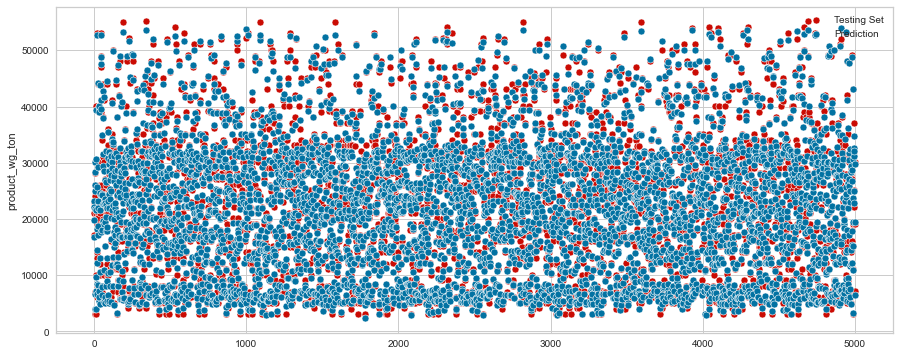

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x=np.arange(len(y_test)), y=y_test, label='Testing Set', color='r', ax=ax)
sns.scatterplot(x=np.arange(len(preds)), y=preds, label='Prediction', ax=ax, color='b')
plt.legend(loc='best')
plt.show()

<AxesSubplot:>

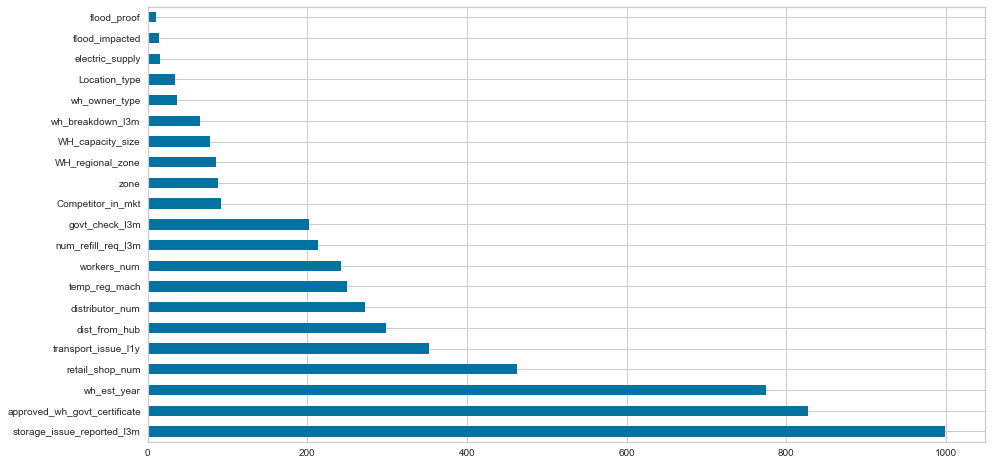

In [26]:
feature_important = reg.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
top100_features_list = data.nlargest(len(X.columns), columns="score")['score'][:100]
bottom100_features_list = data.nlargest(len(X.columns), columns="score")['score'][100:]
data.nlargest(len(X.columns), columns="score")['score'][:50].plot(kind='barh', figsize = (15, 8))

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5
from eli5.sklearn import PermutationImportance
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, learning_curve

In [1]:
X = lgbm_imp_df.drop(['product_wg_ton', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = lgbm_imp_df['product_wg_ton']

reg = xgb.XGBRegressor(eta=0.1, max_depth=5)
train_sizes, train_scores, test_scores = learning_curve(reg, X, y, 
                                                        cv=10, scoring='neg_mean_squared_error', n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

NameError: name 'lgbm_imp_df' is not defined

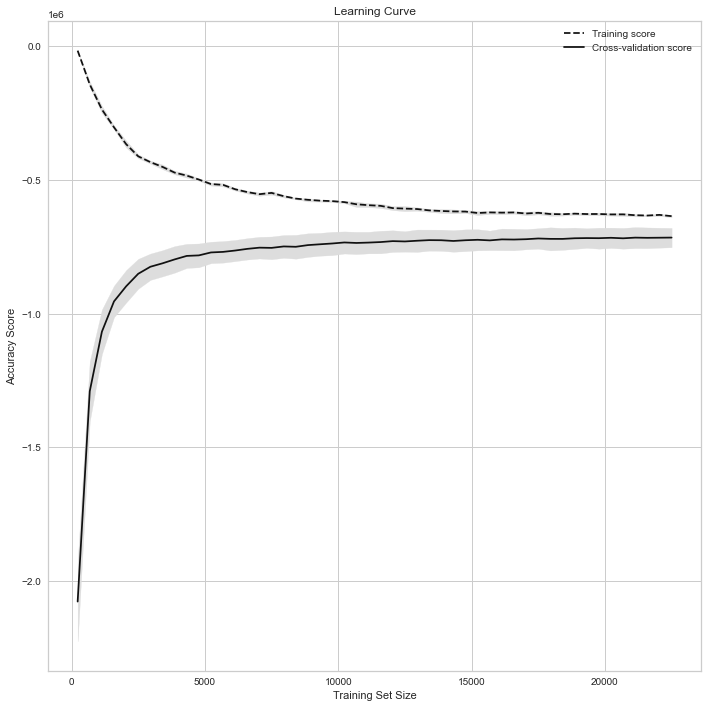

In [32]:
plt.subplots(1, figsize=(10, 10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

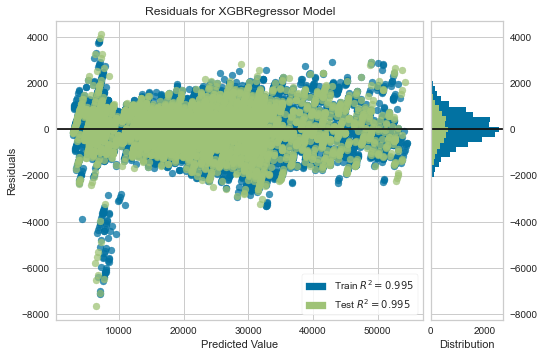

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [33]:
X = lgbm_imp_df.drop(['product_wg_ton', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = lgbm_imp_df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = xgb.XGBRegressor(eta=0.1, max_depth=5)

visualizer = ResidualsPlot(reg)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()   

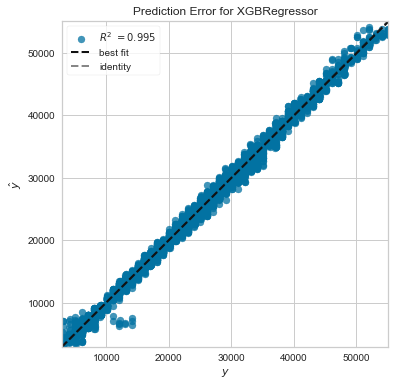

<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [34]:
X = lgbm_imp_df.drop(['product_wg_ton', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = lgbm_imp_df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = xgb.XGBRegressor(eta=0.1, max_depth=5)

visualizer = PredictionError(reg)

plt.figure(figsize=(15, 6))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()   

In [35]:
perm = PermutationImportance(reg, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
2.0275 ± 0.0259,storage_issue_reported_l3m
0.0160 ± 0.0005,approved_wh_govt_certificate
0.0053 ± 0.0001,wh_est_year
0.0019 ± 0.0001,temp_reg_mach
0.0016 ± 0.0001,transport_issue_l1y
0.0002 ± 0.0000,num_refill_req_l3m
0.0001 ± 0.0000,distributor_num
0.0001 ± 0.0000,govt_check_l3m
0.0001 ± 0.0000,workers_num
0.0001 ± 0.0000,retail_shop_num


In [36]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


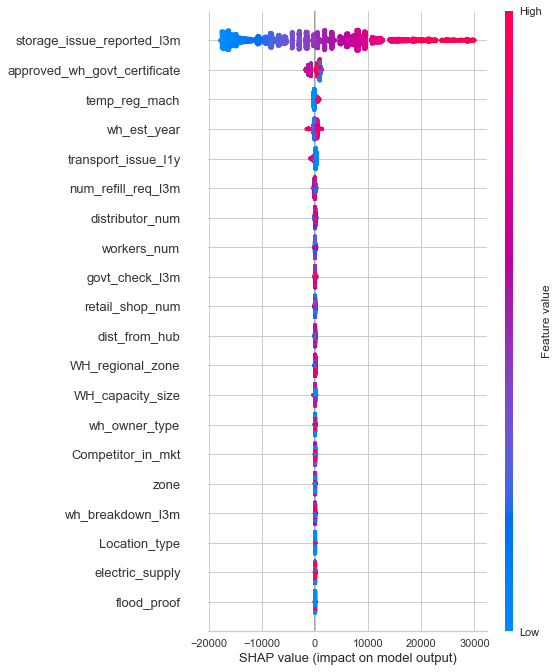

In [37]:
shap.summary_plot(shap_values, X_test)

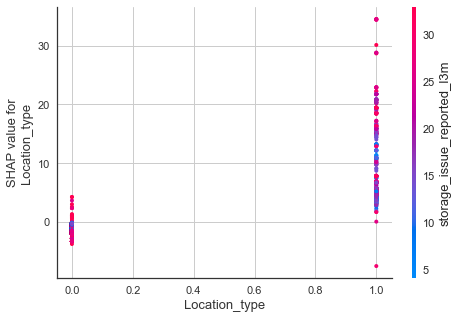

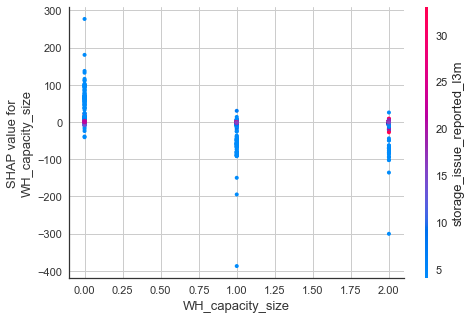

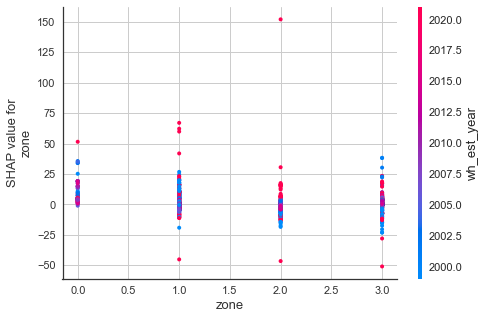

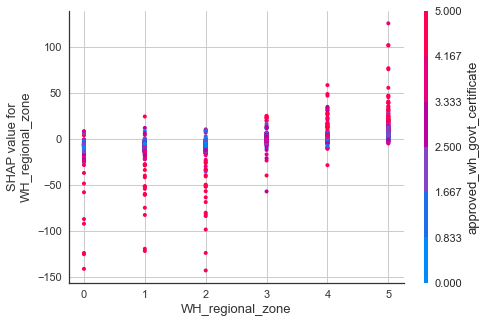

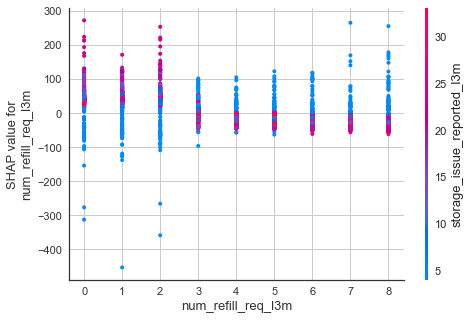

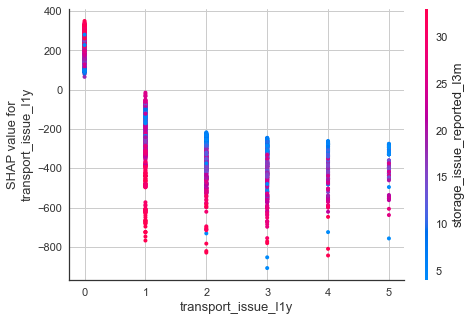

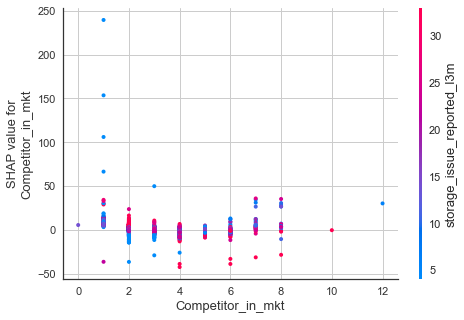

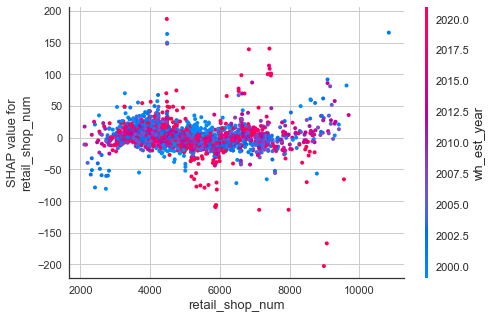

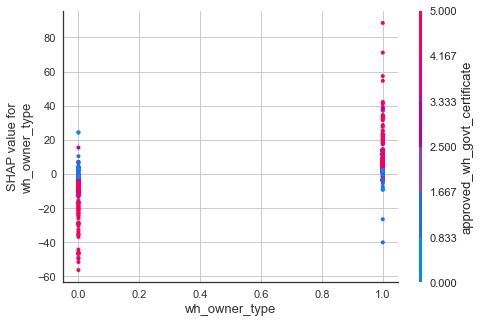

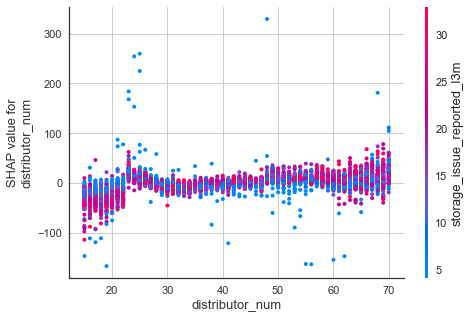

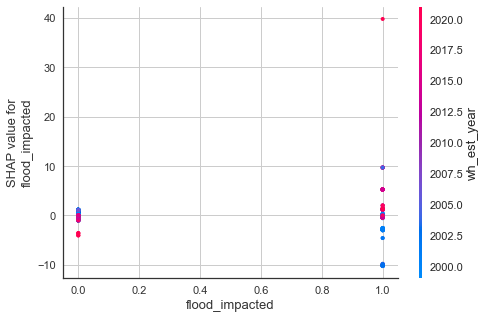

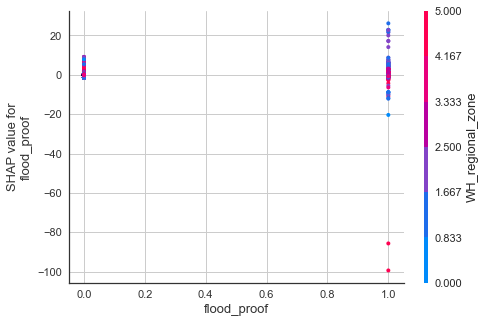

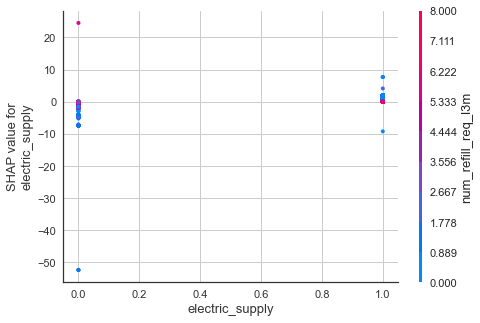

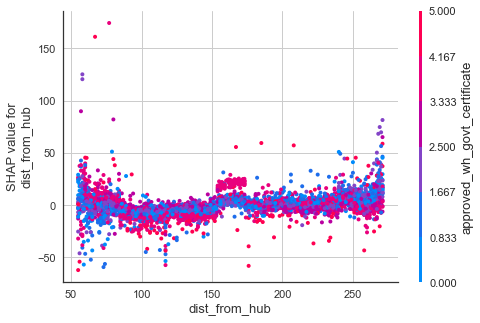

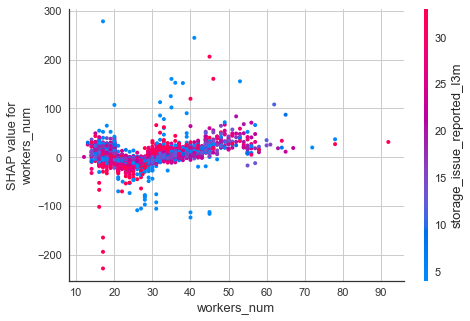

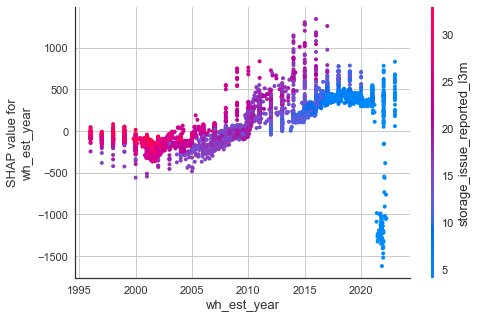

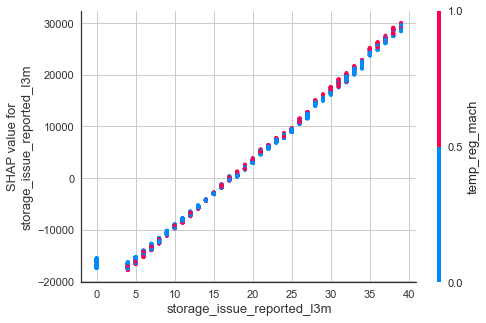

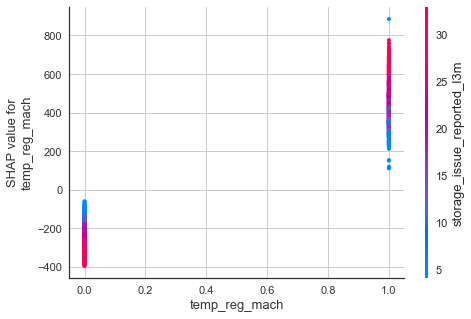

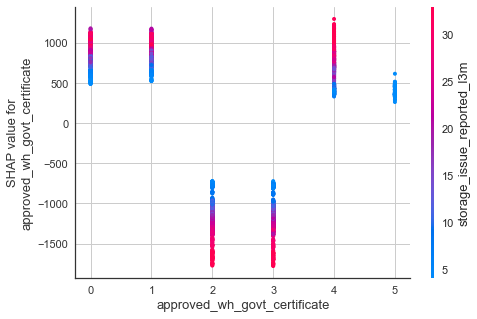

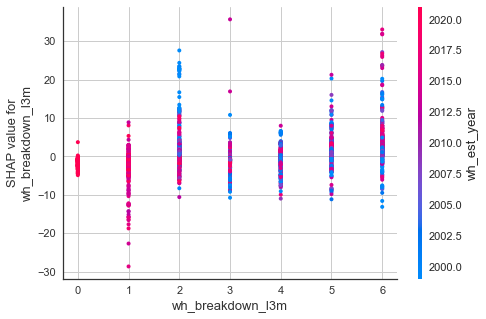

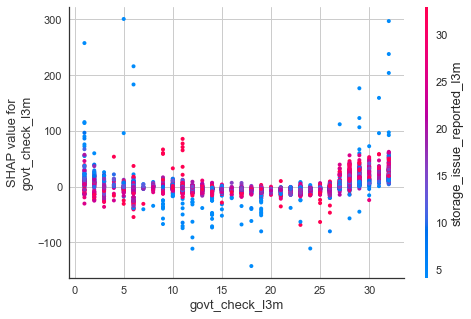

In [38]:
for i in X_train.columns:
    shap.dependence_plot(i, shap_values, X_test)

In [39]:
X = lgbm_imp_df.drop(['product_wg_ton', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = lgbm_imp_df['product_wg_ton']

regressor = xgb.XGBRegressor()
param_grid = {
    'eta': [0.1, 0.3, 0.5, 0.7, 0.9, 0.01, 0.03, 0.05, 0.07, 0.09],
    'max_depth': [3, 5, 7, 9, 11]
    
}
model = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    verbose=10,
    n_jobs=1,
    cv=3
)
model.fit(X, y)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START eta=0.1, max_depth=3.......................................
[CV 1/3; 1/50] END ..eta=0.1, max_depth=3;, score=-801458.059 total time=   0.2s
[CV 2/3; 1/50] START eta=0.1, max_depth=3.......................................
[CV 2/3; 1/50] END ..eta=0.1, max_depth=3;, score=-791252.124 total time=   0.3s
[CV 3/3; 1/50] START eta=0.1, max_depth=3.......................................
[CV 3/3; 1/50] END ..eta=0.1, max_depth=3;, score=-772069.520 total time=   0.4s
[CV 1/3; 2/50] START eta=0.1, max_depth=5.......................................
[CV 1/3; 2/50] END ..eta=0.1, max_depth=5;, score=-739418.386 total time=   0.9s
[CV 2/3; 2/50] START eta=0.1, max_depth=5.......................................
[CV 2/3; 2/50] END ..eta=0.1, max_depth=5;, score=-726666.109 total time=   0.9s
[CV 3/3; 2/50] START eta=0.1, max_depth=5.......................................
[CV 3/3; 2/50] END ..eta=0.1, max_depth=5;, sco

[CV 3/3; 17/50] END .eta=0.7, max_depth=5;, score=-903233.997 total time=   0.9s
[CV 1/3; 18/50] START eta=0.7, max_depth=7......................................
[CV 1/3; 18/50] END eta=0.7, max_depth=7;, score=-1019236.880 total time=   1.5s
[CV 2/3; 18/50] START eta=0.7, max_depth=7......................................
[CV 2/3; 18/50] END .eta=0.7, max_depth=7;, score=-983844.097 total time=   1.2s
[CV 3/3; 18/50] START eta=0.7, max_depth=7......................................
[CV 3/3; 18/50] END eta=0.7, max_depth=7;, score=-1003916.945 total time=   1.3s
[CV 1/3; 19/50] START eta=0.7, max_depth=9......................................
[CV 1/3; 19/50] END eta=0.7, max_depth=9;, score=-1026311.193 total time=   1.8s
[CV 2/3; 19/50] START eta=0.7, max_depth=9......................................
[CV 2/3; 19/50] END eta=0.7, max_depth=9;, score=-1072567.064 total time=   1.9s
[CV 3/3; 19/50] START eta=0.7, max_depth=9......................................
[CV 3/3; 19/50] END eta=0.7,

[CV 3/3; 34/50] END eta=0.03, max_depth=9;, score=-2209662.332 total time=   2.0s
[CV 1/3; 35/50] START eta=0.03, max_depth=11....................................
[CV 1/3; 35/50] END eta=0.03, max_depth=11;, score=-2304166.143 total time=   2.3s
[CV 2/3; 35/50] START eta=0.03, max_depth=11....................................
[CV 2/3; 35/50] END eta=0.03, max_depth=11;, score=-2319216.034 total time=   2.2s
[CV 3/3; 35/50] START eta=0.03, max_depth=11....................................
[CV 3/3; 35/50] END eta=0.03, max_depth=11;, score=-2258407.457 total time=   1.9s
[CV 1/3; 36/50] START eta=0.05, max_depth=3.....................................
[CV 1/3; 36/50] END eta=0.05, max_depth=3;, score=-1033696.715 total time=   0.6s
[CV 2/3; 36/50] START eta=0.05, max_depth=3.....................................
[CV 2/3; 36/50] END eta=0.05, max_depth=3;, score=-1053118.320 total time=   0.5s
[CV 3/3; 36/50] START eta=0.05, max_depth=3.....................................
[CV 3/3; 36/50] END

In [41]:
X = lgbm_imp_df.drop(['product_wg_ton', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = lgbm_imp_df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = xgb.XGBRegressor(eta=0.07, max_depth=7)
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

r2 = metrics.r2_score(y_test, preds)
mae = metrics.mean_absolute_error(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
rmse = metrics.mean_squared_error(y_test, preds, squared=False)
print(f"Squared={r2}")
print(f"Mean Absolute Error={mae}")
print(f"Mean Squared Error={mse}")
print(f"Root Mean Squared Error={rmse}")

Squared=0.9949270714039673
Mean Absolute Error=621.0214102539062
Mean Squared Error=696874.5151158139
Root Mean Squared Error=834.7901024304336
